# Running the RONIN RESNET to evaluate performance

In [1]:
import os
import json
from os import path as osp
import torch
from torch.utils.data import DataLoader
import math
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d

import ronin
from ronin.model_temporal import LSTMSeqNetwork,BilinearLSTMSeqNetwork,TCNSeqNetwork
from ronin.transformations import RandomHoriRotateSeq,ComposeTransform
from ronin.data_glob_speed import GlobSpeedSequence,SequenceToSequenceDataset
from ronin.data_ridi import RIDIGlobSpeedSequence
from ronin.model_resnet1d import ResNet1D,BasicBlock1D,FCOutputModule
from ronin.metric import compute_ate_rte, compute_absolute_trajectory_error,compute_relative_trajectory_error
from ronin.utils import load_config,MSEAverageMeter

## Setting main variables used by the notebook

In [2]:
#define key variables
root_dir = "/data/imu-ml-security-project/Data"
test_list = "../lists/SHORT_list_test_unseen.txt"
out_dir = "../output/lstm_out"
model_path = "/data/imu-ml-security-project/Pretrained_Models/ronin_lstm/checkpoints/ronin_lstm_checkpoint.pt"
cache_path = None
step_size = 10
window_size = 200
max_ori_error = 20.0
cpu = True

#initialize the global variables
_input_channel, _output_channel = 6, 2
_fc_config = {'fc_dim': 512, 'in_dim': 7, 'dropout': 0.5, 'trans_planes': 128}

## Defining Functions used by the notebook

In [3]:
#use the get dataset function
def get_dataset(
        root_dir,
        data_list,
        mode="test",
        step_size=10,
        window_size=200,
        max_ori_error=20,
        dataset="ronin",
        cache_path=None):

    input_format, output_format = [0, 3, 6], [0, _output_channel]

    random_shift, shuffle, transforms, grv_only = 0, False, [], False
    
    if mode == 'train':
        random_shift = step_size // 2
        shuffle = True
        transforms.append(RandomHoriRotateSeq(
            input_format=input_format,
            output_format=output_format
        ))
    elif mode == 'val':
        shuffle = True
    elif mode == 'test':
        shuffle = False
        grv_only = True
    
    #compose the final list of transforms
    transforms = ComposeTransform(transforms)

    if dataset == 'ronin':
        seq_type = GlobSpeedSequence
    elif dataset == 'ridi':
        seq_type = RIDIGlobSpeedSequence
    
    dataset = SequenceToSequenceDataset(
        seq_type=seq_type,
        root_dir=root_dir,
        data_list=data_list,
        cache_path=cache_path,
        step_size=step_size,
        window_size=window_size,
        random_shift=random_shift,
        transform=transforms,
        shuffle=shuffle,
        grv_only=grv_only,
        max_ori_error=max_ori_error
    )

    return dataset

def get_model(config, device, **kwargs):
    if kwargs.get('dropout'):
        config['dropout'] = kwargs.get('dropout')

    if config["type"] == 'tcn':
        network = TCNSeqNetwork(
            _input_channel,
            _output_channel,
            config["kernel_size"],
            layer_channels=config["channels"],
            **kwargs)
        print("TCN Network. Receptive field: {} ".format(
            network.get_receptive_field()))
    elif config["type"] == 'lstm_bi':
        print("Bilinear LSTM Network")
        network = BilinearLSTMSeqNetwork(
            input_size=_input_channel,
            out_size=_output_channel,
            batch_size=config["batch_size"],
            device=device,
            lstm_size=config["layer_size"],
            lstm_layers=config["layers"],
            dropout=config["dropout"]
        ).to(device)
    else:
        print("Simple LSTM Network")
        network = LSTMSeqNetwork(
            _input_channel,
            _output_channel,
            config["batch_size"],
            device,
            lstm_layers=config["layers"],
            lstm_size=config["layer_size"],
            **kwargs).to(device)

    pytorch_total_params = sum(
        p.numel() for p in network.parameters() if p.requires_grad)
    print('Network constructed. trainable parameters: {}'.format(
        pytorch_total_params))
    return network

def recon_traj_with_preds_global(dataset, preds, ind=None, seq_id=0, type='preds', **kwargs):
    ind = ind if ind is not None else np.array(
        [i[1] for i in dataset.index_map if i[0] == seq_id],
        dtype=np.int32)

    if type == 'gt':
        pos = dataset.gt_pos[seq_id][:, :2]
    else:
        ts = dataset.ts[seq_id]
        # Compute the global velocity from local velocity.
        dts = np.mean(ts[ind[1:]] - ts[ind[:-1]])
        pos = preds * dts
        pos[0, :] = dataset.gt_pos[seq_id][0, :2]
        pos = np.cumsum(pos, axis=0)
    veloc = preds
    ori = dataset.orientations[seq_id]

    return pos, veloc, ori

def format_string(*argv, sep=' '):
    result = ''
    for val in argv:
        if isinstance(val, (tuple, list, np.ndarray)):
            for v in val:
                result += format_string(v, sep=sep) + sep
        else:
            result += str(val) + sep
    return result[:-1]

## Preparing to run the code

In [4]:
#setup the list of test datasets
with open(test_list) as f:
    test_data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
print(test_data_list)

#setup the out directory
if not osp.isdir(out_dir):
    os.makedirs(out_dir)


['a006_2', 'a019_3', 'a024_1', 'a024_3', 'a029_1', 'a029_2', 'a032_1', 'a032_3']


In [5]:
#setup the model data
with open(osp.join(str(Path(model_path).parents[1]), 'config.json'), 'r') as f:
        model_data = json.load(f)

#set batch size to 1 for testing
model_data["batch_size"] = 1
#setup cuda
if not torch.cuda.is_available() or cpu:
    device = torch.device('cpu')
    checkpoint = torch.load(
        model_path,
        map_location=lambda storage,
        location: storage)
    print("loaded model to CPU")
else:
    device = torch.device('cuda:0')
    checkpoint = torch.load(model_path)
    print("loaded model to {}".format(device))

loaded model to CPU


/tmp/ipykernel_1181300/4151716006.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


In [6]:
#initializing the dataset
_=get_dataset(
    root_dir=root_dir,
    data_list=[test_data_list[0]],
    mode="test",
    step_size=step_size,
    window_size=window_size,
    max_ori_error=max_ori_error,
    dataset="ronin",
    cache_path=cache_path
)

print("dataset loaded with input channels: {}, output channels: {}".format(
    _input_channel,_output_channel
))

a006_2: device: samsung1, ori_error (game_rv): 3.978
dataset loaded with input channels: 6, output channels: 2


In [7]:
#setup the model
network = get_model(
    config=model_data,
    device=device,
    **model_data["kwargs"]
)
#load the pre-trained weights
network.load_state_dict(checkpoint["model_state_dict"])

#put the model in eval mode
network.eval().to(device)

print('Model {} loaded to device {}.'.format(model_path, device))

Bilinear LSTM Network
Network constructed. trainable parameters: 216620
Model /data/imu-ml-security-project/Pretrained_Models/ronin_lstm/checkpoints/ronin_lstm_checkpoint.pt loaded to device cpu.


In [8]:
log_file = None
if test_list and out_dir:
    log_file = osp.join(
        out_dir,
        osp.split(test_list)[-1].split('.')[0] + '_log.txt')
    with open(log_file, 'w') as f:
        f.write(model_path + '\n')
        f.write('Seq traj_len velocity ate rte\n')

losses_vel = MSEAverageMeter(2, [1], _output_channel)
ate_all, rte_all = [], []
pred_per_min = 200 * 60

## testing against an entire dataset

In [9]:
#load the dataset
dataset_idx = 0
data = test_data_list[dataset_idx]
print("evaluating on dataset: {}".format(test_data_list[dataset_idx]))
seq_dataset = get_dataset(
    root_dir=root_dir,
    data_list=test_data_list,
    mode="test",
    step_size=step_size,
    window_size=window_size,
    max_ori_error=max_ori_error,
    dataset="ronin",
    cache_path=cache_path
)

evaluating on dataset: a006_2
a006_2: device: samsung1, ori_error (game_rv): 3.978
a019_3: device: samsung1, ori_error (game_rv): 1.323
a024_1: device: samsung1, ori_error (game_rv): 10.395
a024_3: device: samsung1, ori_error (game_rv): 3.795
a029_1: device: samsung1, ori_error (game_rv): 18.731
a029_2: device: samsung1, ori_error (game_rv): 10.180
a032_1: device: asus4, ori_error (game_rv): 1.794
a032_3: device: asus4, ori_error (game_rv): 3.553


In [10]:
feat,vel = seq_dataset.get_test_seq(dataset_idx)
feat = torch.Tensor(feat).to(device)
preds = np.squeeze(network(feat).cpu().detach().numpy())[-vel.shape[0]:, :_output_channel]
print("feat shape: {}\nvel shape: {}".format(feat.shape,vel.shape))

feat shape: torch.Size([1, 167569, 6])
vel shape: (167569, 2)


In [23]:
from torch.autograd import Variable

#method to conduct attack
def attack(model, input_image, target):
    #print(input_image.shape)
    #print(target.shape)
    input_image = Variable(input_image, requires_grad=True).to(device)

    pred = model(input_image)

    loss = torch.nn.CrossEntropyLoss()
    loss_val = loss(pred, target)
    loss_val.backward(retain_graph=True)

    grads = torch.sign(input_image.grad.data)#gradients are stored in the input_image.grad variable

    #epsilon = [0.0001, 0.001, 0.0013, 0.009, 0.015, 0.120, 0.25, 0.302] #we add noise based on the epsilon values
    epsilon = 0.302
    adversarial_image = input_image.data + epsilon*grads
    adversarial_pred = model(Variable(adversarial_image)).cpu().detach()

    return adversarial_image, adversarial_pred


def pgd_attack(model, input, target):
    print(input.shape)
    print(target.shape)
    input = Variable(input, requires_grad=True).to(device)
    eps = 0.3
    criterion = torch.nn.CrossEntropyLoss()
    alpha = float(2/255)
    steps = 20

    pred = model(input)
    loss = criterion(pred, target)

    adversarial_input = input.detach()
    adversarial_input += torch.zeros_like(adversarial_input).uniform_(-eps, eps)

    for i in range(steps):
        adversarial_input.requires_grad_()
        adversarial_input = adversarial_input.to(device)

        model.zero_grad()

        adversarial_pred = model(adversarial_input)
        loss = criterion(adversarial_pred, target)
        #loss.backward()

        grad = torch.autograd.grad(loss, [adversarial_input])[0]
        adversarial_input = adversarial_input.detach() + alpha * torch.sign(grad.detach())

        adversarial_input = input + torch.clamp(adversarial_input - input, min=-eps, max=eps)
    
    adversarial_pred = model(adversarial_input)
    adversarial_perturbation = adversarial_input - input

    return adversarial_input, adversarial_pred, adversarial_perturbation


def conduct_attack(network, seq_dataset):

    #put the network in eval mode:
    network.eval()

    one_sample = 0

    feat,vel = seq_dataset.get_test_seq(dataset_idx)
    feat = torch.Tensor(feat).to(device)
    preds = np.squeeze(network(feat).cpu().detach().numpy())[-vel.shape[0]:, :_output_channel]
    print("feat shape: {}\nvel shape: {}".format(feat.shape,vel.shape))

    #make the prediction

    target_direction = torch.stack((torch.Tensor(vel[:,0]),-1*torch.Tensor(vel[:,1])), dim=1).unsqueeze(0) #flip x coordinate as a target direction (go the other way)
    target_direction_torch = target_direction
    # if  one_sample % 10 == 0:
    #     adversarial_input, adversarial_pred, adversarial_perturbation = pgd_attack(input=feat, target=target_direction_torch, model=network)
    # else:
    #     adversarial_input = feat
    #     adversarial_pred = network(adversarial_input)
    adversarial_input, adversarial_pred = attack(input_image=feat, target=target_direction_torch, model=network)
    one_sample += 1

    #save the results
    adversarial_input = adversarial_input.detach().numpy()
    adversarial_pred = np.squeeze(adversarial_pred.numpy())[-vel.shape[0]:, :_output_channel]

    return adversarial_input, adversarial_pred

print("hi")

adversarial_input, adversarial_pred = conduct_attack(network, seq_dataset)
print("done")

hi
feat shape: torch.Size([1, 167569, 6])
vel shape: (167569, 2)
done


Reconstructing trajectory


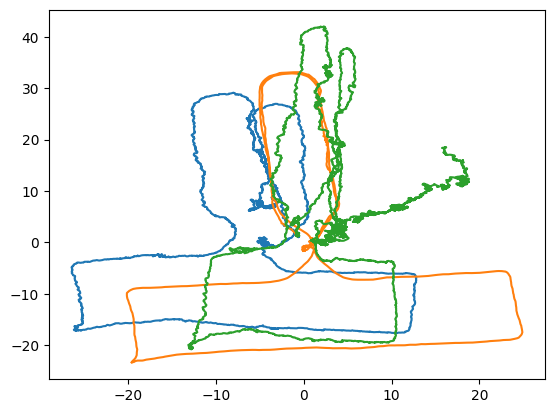

In [25]:
ind = np.arange(vel.shape[0])

print('Reconstructing trajectory')
pos_adv, gv_adv, _ = recon_traj_with_preds_global(
    seq_dataset,
    adversarial_pred,
    ind=ind,
    type='pred',seq_id=dataset_idx)
pos_gt, gv_gt, _ = recon_traj_with_preds_global(
    seq_dataset,
    vel, ind=ind,
    type='gt',
    seq_id=dataset_idx)
pos_pred, gv_pred, _ = recon_traj_with_preds_global(
    seq_dataset,
    preds,
    ind=ind,
    type='pred',seq_id=dataset_idx)

plt.plot(pos_pred[:, 0], pos_pred[:, 1])
plt.plot(pos_gt[:, 0], pos_gt[:, 1])
plt.plot(pos_adv[:, 0], pos_adv[:, 1])

plt.show()

In [15]:
#compute the metrics
ind = np.arange(vel.shape[0])
vel_losses = np.mean((vel - preds) ** 2, axis=0)
losses_vel.add(vel, preds)

print('Reconstructing trajectory')
pos_pred, gv_pred, _ = recon_traj_with_preds_global(
    seq_dataset,
    preds,
    ind=ind,
    type='pred',seq_id=dataset_idx)
pos_gt, gv_gt, _ = recon_traj_with_preds_global(
    seq_dataset,
    vel, ind=ind,
    type='gt',
    seq_id=dataset_idx)

if out_dir is not None and osp.isdir(out_dir):
    np.save(osp.join(out_dir, '{}_{}.npy'.format(
        data, model_data["type"])),
            np.concatenate([pos_pred, pos_gt], axis=1))

ate = compute_absolute_trajectory_error(pos_pred, pos_gt)
if pos_pred.shape[0] < pred_per_min:
    ratio = pred_per_min / pos_pred.shape[0]
    rte = compute_relative_trajectory_error(
        pos_pred, pos_gt, delta=pos_pred.shape[0] - 1) * ratio
else:
    rte = compute_relative_trajectory_error(
        pos_pred, pos_gt, delta=pred_per_min)
pos_cum_error = np.linalg.norm(
    pos_pred - pos_gt, axis=1)
ate_all.append(ate)
rte_all.append(rte)

print('Sequence {}, Velocity loss {} / {}, ATE: {}, RTE:{}'.format(
    data, vel_losses, np.mean(vel_losses), ate, rte))
log_line = format_string(data, np.mean(vel_losses), ate, rte)

Reconstructing trajectory
Sequence a006_2, Velocity loss [0.27905428 0.25911623] / 0.26908525824546814, ATE: 5.936466899619484, RTE:3.0398060178988833


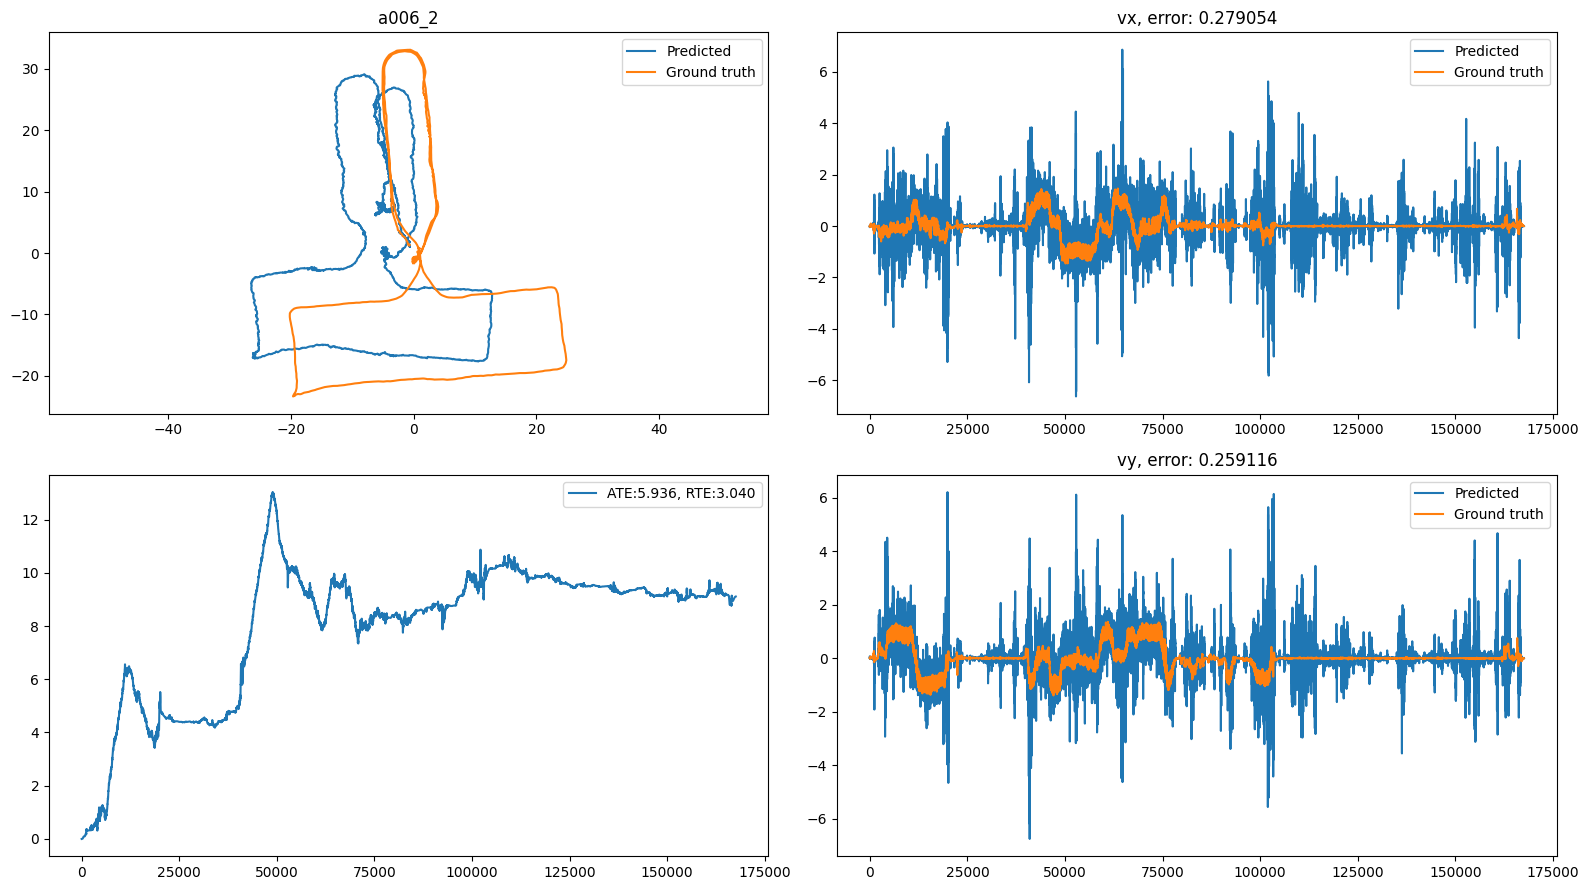

In [16]:
kp = preds.shape[1]
if kp == 2:
    targ_names = ['vx', 'vy']
elif kp == 3:
    targ_names = ['vx', 'vy', 'vz']

plt.figure('{}'.format(data), figsize=(16, 9))
plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
plt.plot(pos_pred[:, 0], pos_pred[:, 1])
plt.plot(pos_gt[:, 0], pos_gt[:, 1])
plt.title(data)
plt.axis('equal')
plt.legend(['Predicted', 'Ground truth'])
plt.subplot2grid((kp, 2), (kp - 1, 0))
plt.plot(pos_cum_error)
plt.legend(['ATE:{:.3f}, RTE:{:.3f}'.format(ate_all[-1], rte_all[-1])])
for i in range(kp):
    plt.subplot2grid((kp, 2), (i, 1))
    plt.plot(ind, preds[:, i])
    plt.plot(ind, vel[:, i])
    plt.legend(['Predicted', 'Ground truth'])
    plt.title('{}, error: {:.6f}'.format(targ_names[i], vel_losses[i]))
plt.tight_layout()
plt.show()